# Setting up our Notebook

In this notebook, the setup and exploration of the environment heavily follows Nicholas Renotte's YouTube tutorial *Build an Mario AI Model with Python | Gaming Reinforcement Learning* at: https://www.youtube.com/watch?v=2eeYqJ0uBKE&t=1982s

The implementation of the A2C algorithm is a modified version of the example script found in *Deep Reinforcement Learning with Python*.

Pertinent Links:

Super Mario RL: https://pypi.org/project/gym-super-mario-bros/

Nes Py: https://pypi.org/project/nes-py/

OpenAI Gym: https://gym.openai.com/

In [1]:
# Standard Imports
import random
import numpy as np
import matplotlib.pyplot as plt

# RL
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Model
import gym
import numpy as np
import seaborn_image as isns
from scipy.signal import convolve, gaussian
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import transforms as T

# Misc
import os
import io
import base64
import time
import glob
from PIL import Image
# from IPython.display import HTML

In [2]:
# Import the game
import gym_super_mario_bros

# Import the Joypad wrapper
from nes_py.wrappers import JoypadSpace # Needed for changing the action space

# Import the SIMPLIFIED controls
from gym_super_mario_bros.actions import RIGHT_ONLY, SIMPLE_MOVEMENT, COMPLEX_MOVEMENT

# Misc
from gym.spaces import Box
from gym.wrappers import FrameStack

# Asychrononous Actor Critic Review

## Basic Overview of Policy Gradient Algorithms

The REINFORCE algorithm starts from the concept of a trajectory, $\large \tau$, generated by an agent taking actions in states according to some policy parameterized (and therefore, an estimate) by $\mathbf{\theta}$:
$$a \sim \hat{\pi}(s, \mathbf{\theta})$$

This action could be discrete, as in this script, in which case the output of $\hat{\pi}(s, \mathbf{\theta})$ is then a *Categorical Distribution* and the action must then be *sampled*, or, in the continuous case, a $d$-dimensional multivariate normal distribution.

The agent follows the policy and generates the trajectory $\large \tau$: 

$$ s_1 \rightarrow a_1 \rightarrow s_2 \rightarrow a_2 \rightarrow .... \rightarrow s_{T-1} \rightarrow a_{T-1} \rightarrow s_T \rightarrow a_T$$ 

The probability of trajectory $\large \tau$ depends on the transition probabilities $p(s_t+1 | s_t, a_t)$ and the policy $\hat{\pi}(s, \mathbf{\theta})$. It is given by the expression:

$$p_\theta(\tau) = p_\theta(s_1, a_1, s_2, a_2, ..., s_T, a_T) = p(s_1)\prod_{t=1}^{T}\hat{\pi}(a_t|s_t,\mathbf{\theta})p(s_{t+1}|s_t,a_t)$$

The expected return from following the policy $\pi$ is given by:

$$J(\theta) = R(\theta)_{expected} = \mathbf{E}_{\tau \sim p_\mathbf{\theta}(\tau)} \left[ \sum_{t=1}^{T} \gamma^{t-1} r_{t+1} \right]$$

After some mathematical manipulation, we can calculate $\nabla_{\theta} J(\theta)$ as:

$$\nabla_{\theta} J(\theta) =  \mathbf{E}_{\tau \sim p_\theta(\tau)} \left[ \left( \sum_{t=1}^{T} \nabla_{\theta} \log{ \hat{\pi}(a_t|s_t,\mathbf{\theta})} \right) \left( \sum_{t=1}^{T} \gamma^{t-1} r_{t+1} \right) \right] $$

We can now replace the outer expectation with an estimate over multiple trajectories to get the following expression for the gradient of policy objective:

$$\nabla_{\theta} J(\theta) \approx  \frac{1}{N} \sum_{i=1}^{N} \left[ \left( \sum_{t=1}^{T} \nabla_{\theta} \log{ \hat{\pi}_\theta(a_t^i|s_t^i,\mathbf{\theta})} \right) \left( \sum_{t=1}^{T} \gamma^{t-1} r_{t+1} \right) \right] $$

where i denotes the $i^{th}$ trajectory. 

Finally, we will use *Gradient Ascent*, as opposed to the normal *Descent*:

$$\mathbf{\theta}_{k+1}=\mathbf{\theta}_k+\eta \nabla _{\mathbf{\theta}_k} J(\mathbf{\theta}_k)$$

## Rewards to Go Trick


We drop the reward terms that came before time t as at time t, the action we take can only impact the reward which comes at time t and later. This leads to changing the 2nd inner sum going from $t’=t$ to $T$ instead of earlier sum over $t’$ going from $t’=1$ to $T$. i.e. the start index is now $t’=t$ and not $t=1$. The revised expression is given below:


$$\nabla_{\theta} J(\theta) \approx  \frac{1}{N} \sum_{i=1}^{N} \left[  \sum_{t=1}^{T}  \left( \nabla_{\theta} \log{ \hat{\pi}(a_t^i|s_t^i, \mathbf{\theta})} \right) \left( \sum_{t'=t}^{T} \gamma^{t'-t} r_{t'+1}^i \right) \right] $$

However, we note that $\sum_{t'=t}^{T} \gamma^{t'-t} r_{t'+1}^i$ is just the Q-value of the state and action at time $t'=t$, so we can replace it with $Q_t ^i = \sum_{t'=t}^{T} \gamma^{t'-t} r_{t'+1}^i$. We now have:

$$\nabla_{\theta} J(\theta) \approx  \frac{1}{N} \sum_{i=1}^{N} \left[ \sum_{t=1}^{T}   \nabla_{\theta} \log{ \hat{\pi}(a_t^i|s_t^i, \mathbf{\theta})} Q_t ^i \right]$$

## Estimating $Q_t ^i$ 

In the REINFORCE algorithm, we actually calculated $Q_t ^i$ from our Monte Carlo simulation. However, we will now estimate this value:

$$ Q_t ^i \approx \hat{Q}_t ^i $$

Now, we will write this as:

$$ \hat{Q}_t ^i = \hat{Q}_t ^i (s_t ^i, a_t ^i, \mathbf{\Theta})$$

## Defining Advantage

We can decompose $\hat{Q}_t ^i$ into:

$$\hat{Q}_t ^i (s_t ^i, a_t ^i, \mathbf{\Theta}) = r(s_t ^i, a_t ^i) +\gamma V(s_{t+1}, \mathbf{\Theta})$$

The way to interpret this is to remember that the Q-value is just the value of taking a specific action $a$ in state $s$ and then continuing to follow some policy $\pi$. Then, following from $s_{t+1}$ is just the state-value function.  

However, is this better than just following policy $\pi$ in state $s$? This question gives us our definition of *Advantage*:

$$A(s) = Q(s,a)-V(s)$$

Now, given that we have decomposed $Q(s,a)$, we can write the advantage as:

$$ A(s) = r(s,a)+\gamma V(s')+V(s)$$

However, we note that we do not have the iteration superscript $i$ on the state inside of the value function. Why? Well, the action value function is the reward received from a single action in a single state plus the average reward from the next state. So, we are no longer considering taking trajectories (yet) for $V$, but saying that our function $V_\mathbf{\Theta}$ already has this taken care of.

We can now write our Advantage into two ways, the *Monte Carlo* version and the *TD(0)* one:

$$ MC: \hat{A}(s_t ^i, a_t ^i) = \sum_{t'=t}^{T} \gamma^{t'-t} r_{t'+1}^i - V(s_t, \mathbf{\Theta})$$

$$ TD(0): \hat{A}(s_t ^i, a_t ^i) = r(s_t ^i, a_t ^i) +\gamma V(s_{t+1}, \mathbf{\Theta})  - V(s_t, \mathbf{\Theta})$$

## Replacing $Q_t ^i$ to get $\nabla_{\theta} J(\theta)$

Now, we just replace $\hat{A}$ with one of the two formulations to get our $\nabla_{\theta} J(\theta)$:

$$\nabla_{\theta} J(\theta) \approx \frac{1}{N} \sum_{i=1}^{N} \left[  \sum_{t=1}^{T}  \left( \nabla_{\theta} \log{ \hat{\pi}(a_t^i|s_t^i, \mathbf{\theta})} \right) \left( \sum_{t'=t}^{T} \gamma^{t'-t} r_{t'+1}^i - V(s_t, \mathbf{\Theta}) \right) \right]$$


$$ \nabla_{\theta} J(\theta) \approx \frac{1}{N} \sum_{i=1}^{N} \left[  \sum_{t=1}^{T}  \left( \nabla_{\theta} \log{ \hat{\pi}(a_t^i|s_t^i, \mathbf{\theta})} \right) \left[ r(s_t ^i, a_t ^i) +\gamma V(s_{t+1}, \mathbf{\Theta})  - V(s_t, \mathbf{\Theta}) \right] \right]$$

## Recasting $\nabla_{\theta} J(\theta)$ as a Loss Function of $(\mathbf{\theta}, \mathbf{\Theta})$

We will implement a pseudo loss function, whose derivative will give us $\nabla_{\theta} J(\theta, \mathbf{\Theta})$. Also. as PyTorch/TensorFlow carryout a gradient Step, we will convert maximization to minimization by changing the sign of this objective function.

$$\mathcal{L}_{CrossEntropy}(\theta, \mathbf{\Theta}) = - J_{approx}(\theta, \mathbf{\Theta}) = - \frac{1}{N} \sum_{i=1}^{N} \left[ \sum_{t=1}^{T} \log{ \pi(a_t^i|s_t^i,\mathbf{\theta})}  \hat{A}_t ^i (\mathbf{\Theta}) \right]$$

We also add a regularization term known as Entropy. The entropy of a distribution is defined as:

$$H(X) = \beta \sum_{x \in X} -p(x)log(p(x))$$

To keep enough exploration, we will want the probability to have a spread out distribution and not let the probability distribution to collapse to a single value or a small region too soon. BIgger the spread of a distribution, higher the entropy $H(x)$ of a distribution. Accordingly, the term fed into PyTorch/TensorFlow minimizer is:


$$\mathcal{L}(\theta, \mathbf{\Theta}) = - J_{approx}(\theta, \mathbf{\Theta}) - H(\mathcal{A}) = - \frac{1}{N} \sum_{i=1}^{N} \left[ \sum_{t=1}^{T} \log{ \pi(a_t^i|s_t^i,\mathbf{\theta})}  \hat{A}_t ^i (\mathbf{\Theta}) - \beta \sum_{a \in \mathcal{A}} \pi(a|s_t^i,\mathbf{\theta})\log{ \pi(a|s_t^i,\mathbf{\theta})} \right] $$

The version of $\hat{A}_t ^i$ to be used is:

$$ \hat{A}(s_t ^i, a_t ^i) = \sum_{t'=t}^{T} \gamma^{t'-t} r_{t'+1}^i - V(s_t ^i, \mathbf{\Theta})$$

Note that we introduced the $i$ superscript in the state-value function.

## Actual Loss Function to be Used

However, like in the REINFORCE algorithm, we will use a slightly simpler version with a single Monte Carlo iteration and averaging over the number of steps:

$$\mathcal{L}(\theta, \mathbf{\Theta}) = - J_{approx}(\theta, \mathbf{\Theta}) - H(\mathcal{A}) = - \frac{1}{T} \left[ \sum_{t=1}^{T} \log{ \pi(a_t|s_t,\mathbf{\theta})}  \hat{A}_t (\mathbf{\Theta}) - \beta \sum_{a \in \mathcal{A}} \pi(a|s_t,\mathbf{\theta})\log{ \pi(a|s_t,\mathbf{\theta})} \right] $$

# Exploring the game

In [3]:
# Setting up the game

env = gym_super_mario_bros.make('SuperMarioBros-v0')

In [4]:
# Exploring the types of movement

print('The RIGHT_ONLY action space:', RIGHT_ONLY)
print('\n')
print('The SIMPLE_ACTION action space:', SIMPLE_MOVEMENT)
print('\n')
print('The COMPLEX_ACTION action space:', COMPLEX_MOVEMENT)

The RIGHT_ONLY action space: [['NOOP'], ['right'], ['right', 'A'], ['right', 'B'], ['right', 'A', 'B']]


The SIMPLE_ACTION action space: [['NOOP'], ['right'], ['right', 'A'], ['right', 'B'], ['right', 'A', 'B'], ['A'], ['left']]


The COMPLEX_ACTION action space: [['NOOP'], ['right'], ['right', 'A'], ['right', 'B'], ['right', 'A', 'B'], ['A'], ['left'], ['left', 'A'], ['left', 'B'], ['left', 'A', 'B'], ['down'], ['up']]


In [5]:
# Exploring the observation space

env.observation_space.shape

(240, 256, 3)

So, we have each frame being 240 $\times$ 256 pixels with 3 channnels (RBG).

Let's choose the simple movements for ease of training.

## Random Actions

In [6]:
# Taking random actions

def random_actions(game, movement, num_actions, render):
    
    """
    game is the game name.
    movements is the type of movement where there are options. 'None' will skip this.
    num_actions is the number of steps.
    render determines if the game will be displayed, determined with True
    """
    rewards = []
    done = True
    env = gym_super_mario_bros.make(game)
    if movement != 'None':
        env = JoypadSpace(env, movement)
    env.reset()

    # Loop through each frame in the game
    for step in range(num_actions): 
        # Do random actions
        state, reward, done, info = env.step(env.action_space.sample())
        if render == True:
            env.render()
        rewards.append(reward)
         
    # Close the game and return the rewards
    env.close()
    return np.sum(rewards)

In [7]:
print('The reward in this trajectory is:', random_actions('SuperMarioBros-v0', SIMPLE_MOVEMENT, 512, True))

C:\Users\chris\anaconda3\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


The reward in this trajectory is: 528


In [8]:
rewards_list = []
n_traj = 100
for i in range(n_traj):
    rewards_list.append(random_actions('SuperMarioBros-v0', SIMPLE_MOVEMENT, 100, False))
print('The average reward after', n_traj, 'trajectories is', np.mean(rewards_list))

The average reward after 100 trajectories is 115.1


# Preprocessing the Environment

In [9]:
# Importing wrappers

# Frame Stacker Wrapper and GrayScaling Wrapper
from gym.wrappers import GrayScaleObservation
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv

In [10]:
# Setting up the environment

def set_up_env(game, movement, grayscale, frame_stacking, frames, order):

    env = gym_super_mario_bros.make(game)
    env = JoypadSpace(env, movement)
    if grayscale == True:
        env = GrayScaleObservation(env, keep_dim=True)
    env = DummyVecEnv([lambda: env])
    if frame_stacking == True:
        env = VecFrameStack(env, frames, channels_order=order)
        
    return env

### Exploring what the GrayScaleObservation and VecFrameStack do

#### VecFrameStack and GrayScaleObservation turned off

In [11]:
env = set_up_env('SuperMarioBros-v0', SIMPLE_MOVEMENT, False, False, 4, 'last')

State Shape (1, 240, 256, 3)


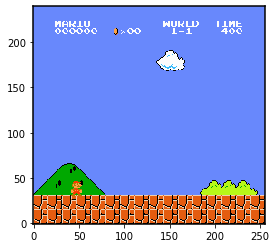

In [12]:
state = env.reset()
print('State Shape', state.shape)
plt.imshow(state[0]).origin='upper'

#### GrayScaleObservation Off and VecFrameStack On

In [13]:
env = set_up_env('SuperMarioBros-v0', SIMPLE_MOVEMENT, False, True, 4, 'last')

State Shape (1, 240, 256, 12)


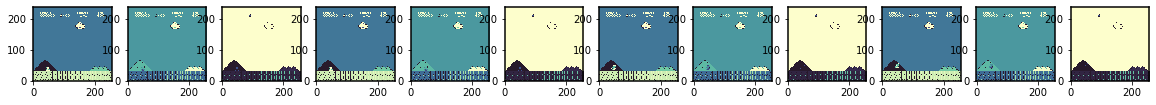

In [14]:
state = env.reset()
print('State Shape', state.shape)
for i in range(0,4): # Filling our vector with images
    state, reward, done, info = env.step([env.action_space.sample()]) # Note that the brackets around the env.action... are
# because we have wrapped it

plt.figure(figsize=(20,20))
for idx in range(12): # So there'll be 4 images with 3 channels
    plt.subplot(1,12,idx+1)
    plt.imshow(state[0][:,:,idx]).origin='upper' # idx is in ranging through 1-4
    plt.show

#### GrayScaleObservation and VecFrameStack On

In [15]:
env = set_up_env('SuperMarioBros-v0', SIMPLE_MOVEMENT, True, True, 4, 'last')

State Shape (1, 240, 256, 4)


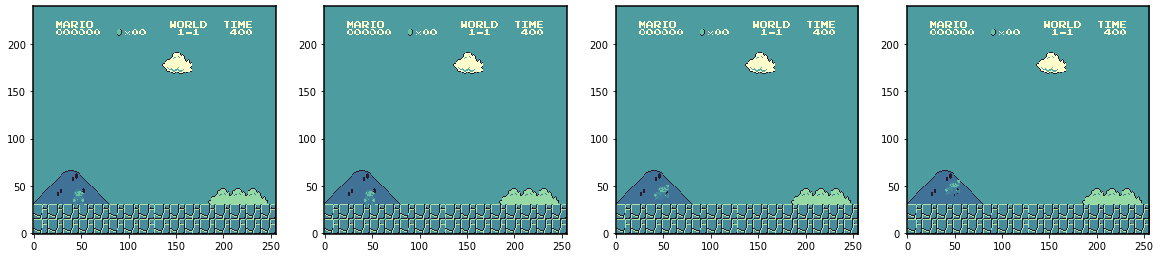

In [16]:
state = env.reset()
print('State Shape', state.shape)
for i in range(0,4): # Filling our vector with images
    state, reward, done, info = env.step([env.action_space.sample()]) # Note that the brackets around the env.action... are
# because we have wrapped it

plt.figure(figsize=(20,20))
for idx in range(state.shape[3]): # So there'll be 4 images
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx]).origin='upper' # idx is in ranging through 1-4
    plt.show

## Setting up the device

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Setting up the Agent

In [18]:
env = set_up_env('SuperMarioBros-v0', SIMPLE_MOVEMENT, True, True, 4, 'last')

In [19]:
# Getting the observation and action shape for our neural net

state_shape, n_actions = env.observation_space.shape, env.action_space.n
state_dim = state_shape
print('State Shape:', state_dim)
print('Number of actions:',n_actions)

State Shape: (240, 256, 4)
Number of actions: 7


In [20]:
# Defining our neural network

class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(in_channels=4, out_channels=32, kernel_size=8, stride=4),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=8, stride=4),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
            nn.Flatten())
        self.actor = nn.Linear(288,n_actions)
        self.critic = nn.Linear(288,1)


    def forward(self, s):
        x = self.conv(s)
        logits = self.actor(x)
        state_value = self.critic(x)
        return logits, state_value
        
model = ActorCritic()
model = model.to(device)

In [21]:
# The state shape is getting messed up as it moves through the wrappers and torch functions, so we make sure it always has
# the right shape

state = env.reset()

def reorder_state(state):
    state = torch.tensor(state, device=device, dtype=torch.float32)
    state = torch.squeeze(state)
    state = state.transpose(0,2)
    state = state.transpose(1,2)
    state = state.unsqueeze(0)
    
    return state
    
state = reorder_state(state)
state.shape

torch.Size([1, 4, 240, 256])

### Predict Action Probabilities

We will use this function to generate the trajectory. It will not be used for doing back propagation. So we will use PyTorch `no_grad()` to avoid gradient calculations. 

In [22]:
# Sampling actions

def sample_action(state):
    """
    params: states: [batch, state_dim]
    returns: probs: [batch, n_actions]
    """
#     state = state.clone().detach()
    state = torch.tensor(state, device=device, dtype=torch.float32)

    with torch.no_grad():
        logits,_ = model(state)
    action_probs = nn.functional.softmax(logits, -1).detach().numpy()[0]
    action = np.random.choice(n_actions, p=action_probs)
    return action

### Play game and generate Trajectory

In [23]:
# Generating a trajectory

def generate_trajectory(env, n_steps=100):
    """
    Play a session and generate a trajectory
    returns: arrays of states, actions, rewards
    """
    states, actions, rewards = [], [], []
    
    # initialize the environment
    s = env.reset()
    s = reorder_state(s)
    
    #generate n_steps of trajectory:
    for t in range(n_steps):
        
        #sample action based on action_probs
        a = sample_action(s)
        next_state, r, done, _ = env.step([a])
        next_state = reorder_state(next_state)
        
        #update arrays
        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = next_state
        if done:
            break
    
    return states, actions, rewards

### Calculate Rewards to Go

 $Q_t ^i = \sum_{t'=t}^{T} \gamma^{t-t'} r_{t'+1}$

In [24]:
# Rewards to Go

def get_rewards_to_go(rewards, gamma=0.99):
    
    T = len(rewards) # total number of individual rewards
    # empty array to return the rewards to go
    rewards_to_go = [0]*T 
    rewards_to_go[T-1] = rewards[T-1]
    
    for i in range(T-2, -1, -1): #go from T-2 to 0
        rewards_to_go[i] = gamma * rewards_to_go[i+1] + rewards[i]
    
    return rewards_to_go

### Train on one trajectory

We will calculate the loss and take a gradient step. We will use Adam Optimizer

**policy network loss:**

We are taking only one trajectory. so N=1. We will, however, average it over the number of actions to get the average loss. So the function we will actually implement is as given below:


$$\mathcal{L}(\theta, \mathbf{\Theta}) = - J_{approx}(\theta, \mathbf{\Theta}) - H(\mathcal{A}) = - \frac{1}{T} \left[ \sum_{t=1}^{T} \log{ \pi(a_t|s_t,\mathbf{\theta})}  \hat{A}_t (\mathbf{\Theta}) - \beta \sum_{a \in \mathcal{A}} \pi(a|s_t,\mathbf{\theta})\log{ \pi(a|s_t,\mathbf{\theta})} \right] $$

In [25]:
# Train on one trajectory

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def train_one_episode(states, actions, rewards, gamma=0.99, entropy_coef=1e-2):
    
    # Get rewards to go
    rewards_to_go = get_rewards_to_go(rewards, gamma)

    # Convert numpy array to torch tensors
    states = torch.stack(states)
    states = states.clone().detach()
    states = states.squeeze(1)
    actions = torch.tensor(actions, device=device, dtype=torch.long)
    rewards_to_go = torch.tensor(rewards_to_go, device=device, dtype=torch.float)
    

    # Get action probabilities from states
    logits, state_values = model(states)
    probs = nn.functional.softmax(logits, -1)
    log_probs = nn.functional.log_softmax(logits, -1)
    
    log_probs_for_actions = log_probs[range(len(actions)), actions]
    
    advantage = rewards_to_go - state_values.squeeze(-1)
    
    # Compute loss to be minized
    J = torch.mean(log_probs_for_actions*(advantage))
    H = -(probs*log_probs).sum(-1).mean()
    
    loss = -(J+entropy_coef*H)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return np.sum(rewards), float(loss) # To show progress on training

### Train the agent

In [26]:
# Training loop

start = time.time()
total_rewards = []
total_losses = []

n_iter = 1000
perf_check = 50
for i in range(n_iter):
    states, actions, rewards = generate_trajectory(env)
    reward, loss = train_one_episode(states, actions, rewards)
    total_rewards.append(reward)
    total_losses.append(loss)
    if i != 0 and i % perf_check == 0:
        print('Iteration:', i)
        mean_reward = np.mean(total_rewards[-perf_check:])
        print("mean reward:%.3f" % (mean_reward))
        mean_loss = np.mean(total_losses[-perf_check:-1])
        print("mean loss:%.3f" % (mean_loss))
env.close()
end = time.time()
print('The training took', round(end-start, 2), 'seconds')

C:\Users\chris\AppData\Local\Temp\ipykernel_13220\2567747441.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, device=device, dtype=torch.float32)
C:\Users\chris\AppData\Local\Temp\ipykernel_13220\2310703893.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:210.)
  rewards_to_go = torch.tensor(rewards_to_go, device=device, dtype=torch.float)


Iteration: 50
mean reward:140.260
mean loss:114.806
Iteration: 100
mean reward:114.620
mean loss:92.051
Iteration: 150
mean reward:137.160
mean loss:103.918
Iteration: 200
mean reward:170.260
mean loss:104.546
Iteration: 250
mean reward:171.700
mean loss:100.053
Iteration: 300
mean reward:170.020
mean loss:103.615
Iteration: 350
mean reward:174.200
mean loss:101.651
Iteration: 400
mean reward:185.020
mean loss:91.280
Iteration: 450
mean reward:195.780
mean loss:82.094
Iteration: 500
mean reward:190.900
mean loss:81.220
Iteration: 550
mean reward:175.320
mean loss:85.985
Iteration: 600
mean reward:159.780
mean loss:78.362
Iteration: 650
mean reward:173.520
mean loss:87.578
Iteration: 700
mean reward:175.500
mean loss:85.455
Iteration: 750
mean reward:180.300
mean loss:83.141
Iteration: 800
mean reward:185.480
mean loss:72.451
Iteration: 850
mean reward:191.480
mean loss:66.011
Iteration: 900
mean reward:196.560
mean loss:62.021
Iteration: 950
mean reward:189.180
mean loss:59.410
The tra

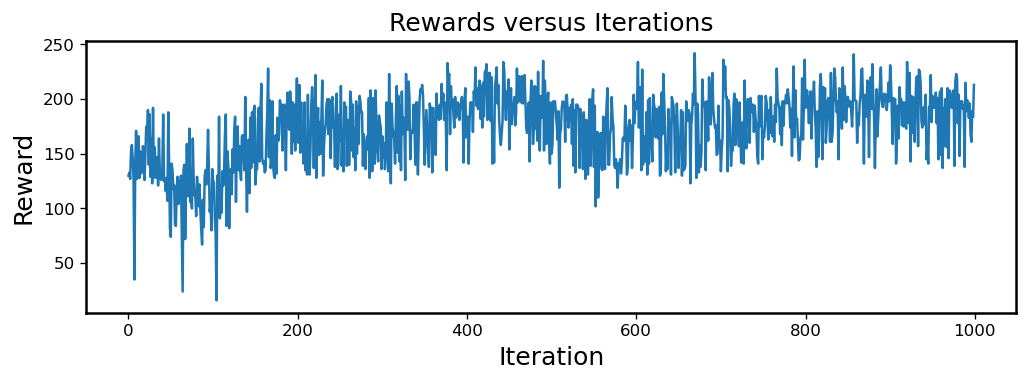

Text(0, 0.5, 'Loss')

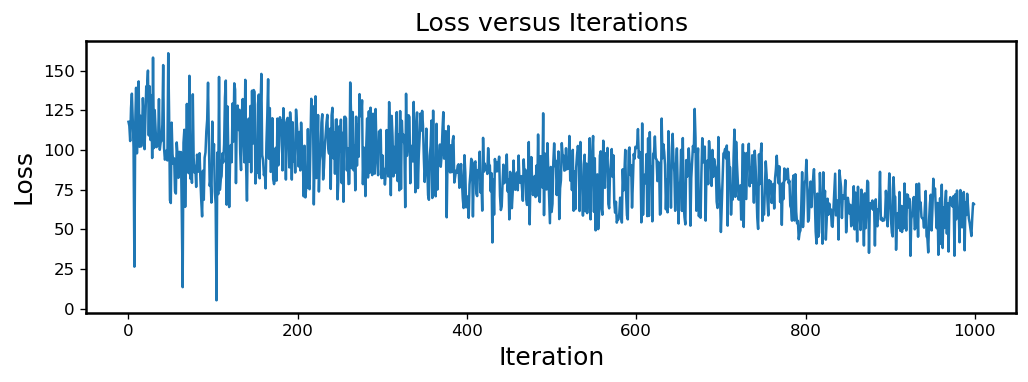

In [27]:
# Plotting the mean rewards and losses per perf_check 

plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(total_rewards)
plt.title('Rewards versus Iterations')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.show()

plt.plot(total_losses)
plt.title('Loss versus Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')

# Evaluating our Agent

In [28]:
# Evaluating our agent

def evaluate_mario(env, render, n_steps=3):
    """
    Play a session and generate a trajectory
    returns: arrays of states, actions, rewards
    """
    """
    Play a session and generate a trajectory
    returns: arrays of states, actions, rewards
    """
    
    env = set_up_env('SuperMarioBros-v0', SIMPLE_MOVEMENT, True, True, 4, 'last')
    
    rewards = []
    
    # initialize the environment
    s = env.reset()
    s = reorder_state(s)
    
    #generate n_steps of trajectory:
    for t in range(n_steps):
        #sample action based on action_probs
        a = sample_action(s)
        next_state, r, done, _ = env.step([a])
        next_state = reorder_state(next_state)
        
        if render == True:
            env.render()
        
        rewards.append(r)

        s = next_state
        if done:
            break

    env.close()
    return np.sum(rewards)

In [34]:
# Single play-through

print('The agent recieved a total reward in one playthrough of', evaluate_mario(env, True, n_steps=1000))

C:\Users\chris\AppData\Local\Temp\ipykernel_13220\2567747441.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, device=device, dtype=torch.float32)


The agent recieved a total reward in one playthrough of 1229.0


In [35]:
# Multiple play-throughs

rewards_list = []
n_traj = 10
for i in range(n_traj):
    rewards_list.append(evaluate_mario(env, False, n_steps=1000))
print('The average reward after', n_traj, 'trajectories is', np.mean(rewards_list))

C:\Users\chris\AppData\Local\Temp\ipykernel_13220\2567747441.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, device=device, dtype=torch.float32)


The average reward after 10 trajectories is 1160.6


# Saving and Reloading

In [36]:
# # Saving an agent

# torch.save(model, 'Models/A2C.h5')

In [32]:
# # Loading an agent

# agent = torch.load('Models/A2C_good.h5')

# # Confirming it has the architecture we want
# agent.eval()